# Create graphiz visualisation

> This module creates the workflow visualisation based on the instances and using the `graphiz` module.

In [ ]:
#| default_exp viz

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import graphviz
from infoflow.classdb import *
from infoflow.creinst import *

The function to create the workflow visualisation for the given `info_items` and `tools`. The function needs all available tools as input and the `info_items` you want the visualisation for. It returns a graphviz.Digraph object that can be rendered in Jupyter notebooks or saved to a file. We will be using the SVG format for the web-application.

In [ ]:
#| export
#TODO: Dit moet anders. Je wil een functie om gegeven alle infoitems te vinden die die tool ondersteunt.

def create_combined_infoflow_viz(info_items, tools):
    if not isinstance(info_items, list): info_items = [info_items]

    # Get all the info_items that are supported by the given tools
    # supported_info_items = set()
    # tool_names = [t.name for t in tools]
    # for i in info_items:
    #     tools_flow = i.toolflow
    #     tools_unique = set()
    #     for t in tools_flow:
    #         if t is None: continue
    #         tools_unique.update(t if isinstance(t, (list, tuple)) else [t])
    #     if tools_unique.issubset(tool_names):
    #         supported_info_items.add(i)
        
    #     for t in tools:
    #         if i in t.info_items:
    #             supported_info_items.append(i)
    #             break # If found at least one, break to avoid useless iterations
    # info_items = supported_info_items
    
    dot = graphviz.Digraph(comment='PKM Workflow')
    dot.attr(rankdir='TB')
    
    phases = ['collect', 'retrieve', 'consume', 'extract', 'refine']
    all_nodes = set()
    edges = {}
    
    quality_colors = {PhaseQuality.GREAT: 'lightgreen', PhaseQuality.OK: 'lightblue', PhaseQuality.BAD: 'orange', PhaseQuality.NA: 'lightgray'}

    
    
    for phase in phases:
        with dot.subgraph() as s:
            s.attr(rank='same')
            for info_item in info_items:
                i = phases.index(phase)
                if i < len(info_item.toolflow) and info_item.toolflow[i] is not None:
                    tool_entry = info_item.toolflow[i]
                    if isinstance(tool_entry, tuple): tools_in_phase = tool_entry
                    else: tools_in_phase = (tool_entry,)
                    
                    for tool_name in tools_in_phase:
                        if tool_name is not None:
                            node_id = f"{tool_name.lower()}_{phase}"
                            if node_id not in all_nodes:
                                tool = next((t for t in tools if t.name == tool_name), None)
                                color = quality_colors[tool.phase_quality[i]] if tool else 'white'
                                s.node(node_id, f"{tool_name}\n({phase})", shape='hexagon', fillcolor=color, style='filled')
                                all_nodes.add(node_id)
    
    with dot.subgraph() as s:
        s.attr(rank='same')
        for info_item in info_items:
            source_id = f"source_{info_item.info_type.value}"
            s.node(source_id, info_item.info_type.value.replace('_', ' ').title(), shape='box')
    
    for info_item in info_items:
        source_id = f"source_{info_item.info_type.value}"
        previous_nodes = [source_id]
        
        for i, tool_entry in enumerate(info_item.toolflow):
            if i < len(phases) and tool_entry is not None:
                phase = phases[i]
                current_nodes = []
                
                if isinstance(tool_entry, tuple): tools_in_phase = tool_entry
                else: tools_in_phase = (tool_entry,)
                
                for tool_name in tools_in_phase:
                    if tool_name is not None:
                        node_id = f"{tool_name.lower()}_{phase}"
                        current_nodes.append(node_id)
                        
                        for prev_node in previous_nodes:
                            edge_key = (prev_node, node_id)
                            if edge_key not in edges:
                                dot.edge(prev_node, node_id)
                                edges[edge_key] = True
                
                if current_nodes: previous_nodes = current_nodes
    
    return dot

An example for creating the actual visualisation for the given `info_items` and `tools`.

In [ ]:
# tools = [reader, recall, readwise, obsidian, librarything, snipd, neoreader, youtube]
# items = [note_item, web_article_item, annotation_item, book_item, youtube_video_item, podcast_item, research_paper_item, document_item]
tools_from_code()
informationitems_from_code()

In [ ]:
tools = Tool.get_instances()
items = InformationItem.get_instances()

In [ ]:
set(items)

TypeError: unhashable type: 'InformationItem'

In [ ]:
for i in items:
    print(i)

name='Web Article' info_type=<InformationType.WEB_ARTICLE: 'web_article'> method=[<Method.MANUAL: 'manual'>, None, None, None, None] toolflow=[['Reader', 'Recall'], 'Recall', 'Reader', None, None]
name='Annotation' info_type=<InformationType.ANNOTATION: 'annotations&highlights'> method=[<Method.AUTOMATIC: 'automatic'>, None, None, None, None] toolflow=[None, None, None, 'Readwise', ['Recall', 'Obsidian']]
name='Note' info_type=<InformationType.NOTE: 'note'> method=[<Method.MANUAL: 'manual'>, None, None, None, None] toolflow=[None, 'Obsidian', 'Obsidian', 'Obsidian', 'Obsidian']
name='Book' info_type=<InformationType.BOOK: 'book'> method=[<Method.MANUAL: 'manual'>, None, None, None, None] toolflow=['LibraryThing', 'LibraryThing', 'NeoReader', 'Readwise', 'Obsidian']
name='Podcast' info_type=<InformationType.PODCAST: 'podcast'> method=[<Method.AUTOMATIC: 'automatic'>, None, None, None, None] toolflow=['Snipd', 'Snipd', 'Snipd', 'Readwise', 'Obsidian']
name='Research Paper' info_type=<Inf

In [ ]:
viz = create_combined_infoflow_viz(items, tools)

AttributeError: 'list' object has no attribute 'lower'

In [ ]:
type(viz)

graphviz.graphs.Digraph

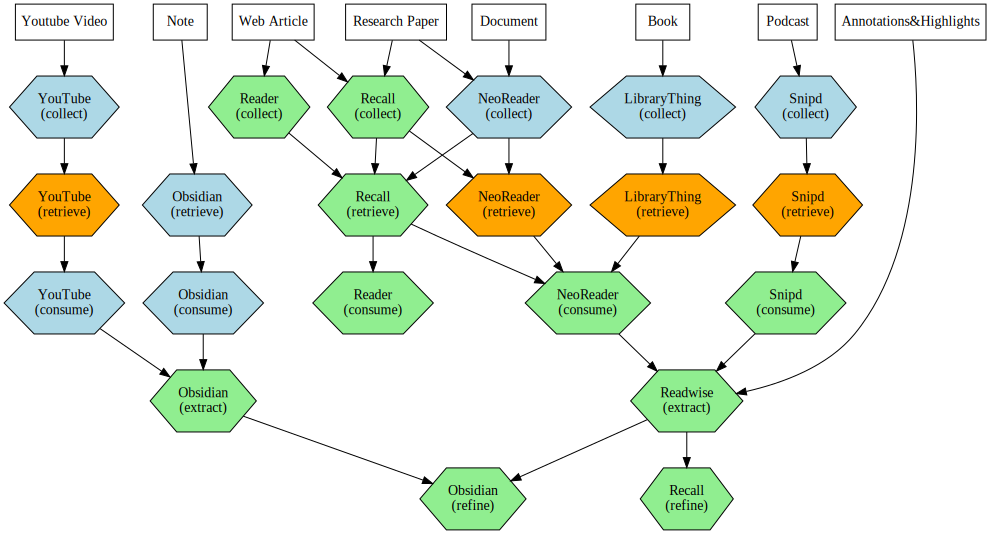

In [ ]:
viz

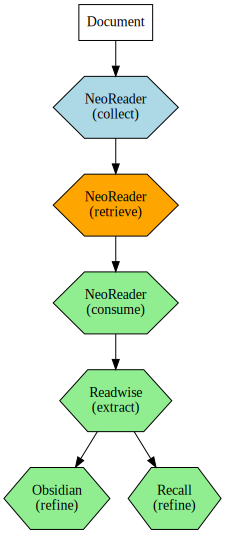

In [ ]:
viz_document = create_combined_infoflow_viz([document_item], tools)
viz_document

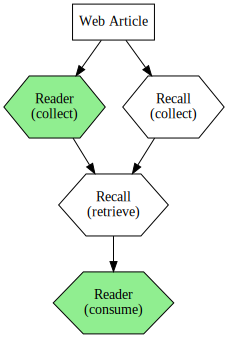

In [ ]:
viz_tool = create_combined_infoflow_viz(items, [reader])
viz_tool

To get the `SVG` output, you can use the `_repr_image_svg_xml` method of the `Digraph` object. Below is an example showing the first 200 characters.

In [ ]:
viz._repr_image_svg_xml()[:200]

'<?xml version="1.0" encoding="UTF-8" standalone="no"?>\n<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"\n "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">\n<!-- Generated by graphviz version 2.43.0 (0)'

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()